In [1]:
import sys
sys.path.insert(1, '..')
from utils import *
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from scipy.stats import gmean
import seaborn as sns
from pyswarms.single.global_best import GlobalBestPSO

%matplotlib inline

In [2]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path'] 
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']
AREA_NAME = 'NYC'

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

HUFF_MODEL_SAVE_DIR = join(pwd, util_datasets, 'huff_model_params')
if not os.path.isdir(HUFF_MODEL_SAVE_DIR):
    os.mkdir(HUFF_MODEL_SAVE_DIR)

In [3]:
def get_cbg_locs(selected_cbgs=None):
    nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
    base_df = gpd.read_file(nyc_geojson)
    base_df = base_df.to_crs('EPSG:4326')
    base_df = base_df[base_df.BLKGRPCE != '0']
    
    if isinstance(selected_cbgs, str):
        base_df = base_df[base_df.GEOID.str[:5] == selected_cbgs]
    elif isinstance(selected_cbgs, set):
        base_df = base_df[base_df.GEOID.isin(selected_cbgs)]
        
    base_df['GEOID'] = base_df['GEOID'].astype(str).str[:-1]
    base_df = base_df.dissolve(by='GEOID', as_index=False)
    
    base_df['centroid_lon'] = base_df.geometry.centroid.x
    base_df['centroid_lat'] = base_df.geometry.centroid.y
    cbg_locs = base_df[['GEOID', 'centroid_lat', 'centroid_lon']].set_index('GEOID')
    
    return cbg_locs

In [4]:
def get_poi_areas(pois):
    poi_ids = pd.read_csv(join(pwd, util_datasets, 'safegraph_poi_areas.csv'), usecols=['safegraph_place_id', 'area_square_feet'], index_col='safegraph_place_id')
    return pois.join(poi_ids, how='inner')

def get_poi_attrs(poi_cat=None):
    poi_dir = join(pwd, dpath, 'area-pois', AREA_NAME)
    dfs = []
    for f in os.listdir(poi_dir):
        df = pd.read_csv(join(poi_dir, f))
        if poi_cat:
            df = df[df['top_category'] == poi_cat]
        dfs.append(df)

    df = pd.concat(dfs).drop_duplicates(subset=['safegraph_place_id'])

    poi_locs = df[['safegraph_place_id', 'latitude', 'longitude']].set_index('safegraph_place_id')
    res = get_poi_areas(poi_locs)
    return res[['latitude', 'longitude']], res[['area_square_feet']]

def get_cbg_poi_div_count():
    # return the poi count and diversity in the given cbgs
    shape_files = join(pwd, 'util_datasets', 'NY-msa-shapefiles')
    target_county_fips = set(pd.read_csv(join(pwd, 'util_datasets', 'NY-msa-counties.csv'))['fips'].astype(str))
    
    dfs = []
    for sh in os.listdir(shape_files):
        df = gpd.read_file(join(shape_files, sh))
        dfs.append(df[df['GEOID'].str[:5].isin(target_county_fips)][['GEOID', 'geometry']])
        
    tracts = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))
    
    tracts['GEOID'] = tracts['GEOID'].astype(str).str[:-1]
    tracts = tracts.dissolve(by='GEOID', as_index=False)
        
    poi_dir = join(pwd, dpath, 'area-pois', AREA_NAME)
    dfs = []
    for f in tqdm(os.listdir(poi_dir)):
        df = pd.read_csv(join(poi_dir, f), usecols=['safegraph_place_id', 'top_category', 'latitude', 'longitude'])
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
        dfs.append(gpd.sjoin(gdf, tracts, how='inner', op='within'))
        
    df = pd.concat(dfs).drop_duplicates(subset=['safegraph_place_id'])
    grouped = df.groupby('GEOID')
    diversity = grouped.apply(lambda x: len(x['top_category'].unique()))
    count = grouped.apply(lambda x: x['top_category'].shape[0])
    
    df = df.merge(diversity.rename('poi_diversity_where_store_is'), left_on='GEOID', right_index=True)
    res = df.merge(count.rename('poi_count_where_store_is'), left_on='GEOID', right_index=True)
    return res[['safegraph_place_id', 'poi_diversity_where_store_is', 'poi_count_where_store_is', 'GEOID']]

In [5]:
def match_poi2cbg(poi_locs):
    nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
    base_df = gpd.read_file(nyc_geojson)
    base_df = base_df.to_crs('EPSG:4326')
    base_df = base_df[base_df.BLKGRPCE != '0']
    base_df = base_df[['GEOID', 'geometry']]
    
#     base_df['GEOID'] = base_df['GEOID'].astype(str).str[:-1]
#     base_df = base_df.dissolve(by='GEOID', as_index=False)
    
    gdf = gpd.GeoDataFrame(poi_locs.copy(), geometry=gpd.points_from_xy(poi_locs.longitude, poi_locs.latitude))
    
    return gpd.sjoin(gdf, base_df, how='inner', op='within')

In [6]:
def get_nvisits(row, cbg_visits, keys):
    poi = row['safegraph_place_id']
    entries = json.loads(row['visitor_home_cbgs'])
    for cbg in entries.keys():
        ct = cbg[:-1]
        if ct in keys:
            cbg_visits.loc[ct, poi] += entries[cbg]

In [7]:
def agg_visits_by_cbgs(distance_mat, pattern_files):
    cbg_visits = pd.DataFrame(np.zeros(distance_mat.shape), index=distance_mat.index, columns=distance_mat.columns)
    cbg_lookup = set(distance_mat.index)
    poi_lookup = set(distance_mat.columns)
    
    for f in tqdm(pattern_files):
        df = pd.read_csv(f)
        df = df[df.safegraph_place_id.isin(poi_lookup)]
        df.apply(get_nvisits, cbg_visits=cbg_visits, keys=cbg_lookup, axis=1)

    return cbg_visits

In [8]:
def get_spreader_cbgs(pct=0.75):
    spreader_cbgs = pd.read_csv(join(pwd, util_datasets, 'nyc_spreader_rank.csv'))
    return spreader_cbgs[spreader_cbgs['rank'] >= pct].cbg.astype(str).values

def gen_rand_loc(c_lat, c_lng, r=1000):
    # https://github.com/rmrs/random-location/blob/master/src/index.js
    sin_lat = np.sin(np.radians(c_lat))
    cos_lat = np.cos(np.radians(c_lat))
    
    bearing = np.random.rand() * np.pi * 2
    sin_bearing = np.sin(bearing)
    cos_bearing = np.cos(bearing)
    
    t = r / 6371000
    sint = np.sin(t)
    cost = np.cos(t)
    
    rlat = np.arcsin(sin_lat * cost + cos_lat * sint * cos_bearing)
    rlng = np.radians(c_lng) + np.arctan2(sin_bearing * sint * cos_lat, cost - sin_lat * np.sin(rlat))
    rlng = ((rlng + np.pi*3) % (np.pi*2)) - np.pi;
    
    to_deg = lambda rad: rad / (np.pi / 180)
    
    return [to_deg(rlat), to_deg(rlng)]

In [9]:
def comp_dist_matrix(cbg_locs, poi_locs, betas=None):
    dist_matrix = pd.DataFrame(haversine_distances(np.radians(cbg_locs), np.radians(poi_locs)) * 6371, index=cbg_locs.index, columns=poi_locs.index)
    # dist_matrix = 1/dist_matrix
    
    if isinstance(betas, set):
        for cbg, beta in betas.items():
            dist_matrix.loc[cbg] *= beta

    return dist_matrix #dist_matrix.div(dist_matrix.sum(axis=1), axis=0)

def get_cbg_visits(dist_mat):
    pattern_dir = join(pwd, dpath, 'filtered-patterns-msa', 'NYC-patterns')
    date_format = '%Y-%m-%d'
    pattern_files = [(datetime.strptime(f.split('.')[0], date_format), join(pattern_dir, f)) for f in os.listdir(pattern_dir)]

    patterns = []
    for dt, f in pattern_files:
        if dt >= start_date and dt <= end_date:
            patterns.append(f)

    return agg_visits_by_cbgs(dist_mat, patterns)

In [10]:
def ols_huff_params(agg_visits, dist_mat, poi_areas, cbg_poi_div, cbg_poi_counts):
    # https://www.esri.com/content/dam/esrisites/sitecore-archive/Files/Pdfs/library/whitepapers/pdfs/calibrating-huff-model.pdf
    cbgs = dist_mat.index
    model_params = []
    cbg_vec = set(cbg_poi_div.index)
    
    # geometric mean of poi areas
    a_j = gmean(poi_areas.area_square_feet.values)
    
    for cbg in tqdm(cbgs):
        poi_visits = agg_visits.loc[cbg]
        p_ij = (poi_visits / poi_visits.sum()) + 1e-8
        
        if p_ij.shape[0] == 0:
            continue
        
        # geometric mean of p_ij
        p_i_hat = gmean(p_ij)
        # geometric mean of D_ij
        d_i = gmean(dist_mat.loc[cbg])
        
        reg_table = pd.DataFrame(p_ij)
        reg_table.columns = ['p_ij']
        
        reg_table['p_ij'] = reg_table['p_ij'] / p_i_hat
        reg_table['area'] = 0
        reg_table['distance'] = 0
        reg_table['poi_diversity'] = cbg_poi_div[cbg] if cbg in cbg_vec else 1
        reg_table['poi_count'] = cbg_poi_counts[cbg] if cbg in cbg_vec else 1

        for ind in reg_table.index:
            reg_table.loc[ind, 'distance'] = dist_mat.loc[cbg, ind] / d_i
            reg_table.loc[ind, 'area'] = poi_areas.loc[ind, 'area_square_feet'] / a_j

        reg_table = np.log(reg_table)
#         reg_table = reg_table.replace([np.inf, -np.inf], np.nan)
#         reg_table = reg_table.dropna()
        
        features = reg_table.drop('p_ij', axis=1)
        
        model = sm.OLS(reg_table['p_ij'], features)
        results = model.fit()
        cbg_params = {'cbg': cbg}
        for c, p in zip(features.columns, results.params):
            cbg_params[c] = p
        model_params.append(cbg_params)
        with open(join(HUFF_MODEL_SAVE_DIR, f'{cbg}-all-features.txt'), 'w') as fl:
            fl.write(results.summary().as_text())
    
    return model_params

In [11]:
def scale_range(values, new_min=1, new_max=10):
    old_min = np.min(values)
    old_max = np.max(values)
    
    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    return (((values - old_min) * new_range) / old_range) + new_min

def huff_corr(cbg_table, exp_distance, exp_area, exp_poi_diversity, exp_poi_count, get_corr=False):
    numerator = (cbg_table['area_square_feet']**exp_area) * (cbg_table['poi_diversity_where_store_is']**exp_poi_diversity) * (cbg_table['poi_count_where_store_is']**exp_poi_count)
    cbg_table['sim_nvisits'] = numerator / (cbg_table['distance']**exp_distance)
    
    if cbg_table['sim_nvisits'].sum() != 0:
        cbg_table['sim_nvisits'] /= cbg_table['sim_nvisits'].sum()

    #cbg_table = cbg_table[~cbg_table['sim_nvisits'].isin([np.nan, np.inf, -np.inf])]
    
    corr_res = stats.pearsonr(cbg_table['nvisits'] / cbg_table['nvisits'].sum(), cbg_table['sim_nvisits'])
    
    if get_corr:
        return corr_res
    return 1 - corr_res[0]

def obj_func(X, cbg_table):
    n_particles = X.shape[0]
    cost = [huff_corr(cbg_table, *X[i]) for i in range(n_particles)]
    return np.array(cost)

def pso_huff_params(cbg_table, iters=10, init_pos=None, n_particles=20):
    constraints = (np.array([1, 1, 1, 1]), np.array([100, 100, 100, 100]))
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.9}
    optimizer = GlobalBestPSO(n_particles=n_particles,
                    dimensions=4,
                    options=options,
                    bounds=constraints,
                    init_pos=init_pos)
    cost, joint_vars = optimizer.optimize(obj_func, iters=iters, cbg_table=cbg_table, verbose=False)
    return cost, joint_vars

In [12]:
def huff_param_borough(borough, poi_locs, poi_areas, poi_cbg_ids, start_date, end_date, cbg_poi_div, cbg_poi_counts):    
    selected_cbsg = str(nyc_borough2fips[borough])
    cbg_locs = get_cbg_locs(selected_cbgs=selected_cbsg)    

    dist_mat = comp_dist_matrix(cbg_locs, poi_locs)

    poi_cbg_visits = get_cbg_visits(dist_mat)
    
#     dists = []
#     area_lst = []
#     for cbg in dist_mat.index:
#         visits = poi_cbg_visits.loc[cbg]
#         visits = visits[visits > 0]
#         dist = dist_mat.loc[cbg, visits.index]
#         dists.extend(list(dist.repeat(visits.astype(int).values)))
        
#     print(borough, np.median(dists))

    return ols_huff_params(poi_cbg_visits, dist_mat, poi_areas, cbg_poi_div, cbg_poi_counts)

In [13]:
# boroughs = list(nyc_borough2fips.keys())
# borough = 'Staten Island'
# poi_cat = 'Grocery Stores'
# start_date = datetime(2020, 3, 22)
# end_date = datetime(2020, 6, 8)

# poi_locs, poi_areas = get_poi_attrs(poi_cat=poi_cat)
# poi_cbg_ids = match_poi2cbg(poi_locs)

In [15]:
boroughs = list(nyc_borough2fips.keys())
#borough = 'Staten Island'
poi_cat = 'Grocery Stores'
start_date = datetime(2020, 3, 22)
end_date = datetime(2020, 6, 8)

poi_locs, poi_areas = get_poi_attrs(poi_cat=poi_cat)
poi_cbg_ids = match_poi2cbg(poi_locs)

for borough in boroughs:
    if os.path.exists(join(HUFF_MODEL_SAVE_DIR, f'{borough}-{poi_cat}-all-features-ctract-detailed.csv')):
        continue
    selected_cbsg = str(nyc_borough2fips[borough])
    cbg_locs = get_cbg_locs(selected_cbgs=selected_cbsg)
    dist_mat = comp_dist_matrix(cbg_locs, poi_locs)

    poi_div_count = get_cbg_poi_div_count()
    poi_cbg_visits = get_cbg_visits(dist_mat)

    n_particles = 20
    iters = 500
    cbg_exps = []
    for cbg in tqdm(dist_mat.index):
        visits = poi_cbg_visits.loc[cbg].rename('nvisits')

        if visits.sum() == 0:
            continue

        dist = dist_mat.loc[cbg].rename('distance')

        table = pd.concat([visits, dist, poi_areas, poi_div_count.dropna().set_index('safegraph_place_id').drop('GEOID', axis=1)], axis=1, join='inner')
        features = table.columns.tolist()
        features.remove('nvisits')

        for f in features:
            table[f] = scale_range(table[f].values)

        params = pso_huff_params(table, iters=iters, n_particles=n_particles)
        corr = huff_corr(table, *params[1], get_corr=True)

        cbg_exps.append({'census_tract': cbg,
                         'exp_distance': params[1][0],
                         'exp_area': params[1][1], 
                         'exp_poi_diversity': params[1][2], 
                         'exp_poi_count': params[1][3], 
                         'corr': corr[0], 
                         'p': corr[1]})

    pd.DataFrame(cbg_exps).to_csv(join(HUFF_MODEL_SAVE_DIR, f'{borough}-{poi_cat}-all-features-ctract-detailed.csv'), index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 760/760 [5:36:25<00:00, 26.56s/it]


In [29]:
dfs = []
for f in os.listdir(HUFF_MODEL_SAVE_DIR):
    if 'ctract-detailed' in f:
        dfs.append(pd.read_csv(join(HUFF_MODEL_SAVE_DIR, f)))
res = pd.concat(dfs, axis=0)
res['borough'] = res['census_tract'].apply(lambda x: nyc_fips2borough[int(str(x)[:5])])

In [30]:
res.head()

,census_tract,exp_distance,exp_area,exp_poi_diversity,exp_poi_count,corr,p,borough
0,36005000100,83.316688,75.373961,39.669220,16.351635,-0.000299,9.767938e-01,Bronx
1,36005000200,95.186448,3.569657,1.089487,6.658740,0.008257,4.219422e-01,Bronx
2,36005000400,99.575703,1.529885,12.270193,2.576492,0.088526,6.324012e-18,Bronx
3,36005001600,76.834447,1.709444,3.182149,8.284312,0.211582,3.270160e-96,Bronx
4,36005001900,68.780164,6.297623,5.592525,1.547692,0.385190,0.000000e+00,Bronx


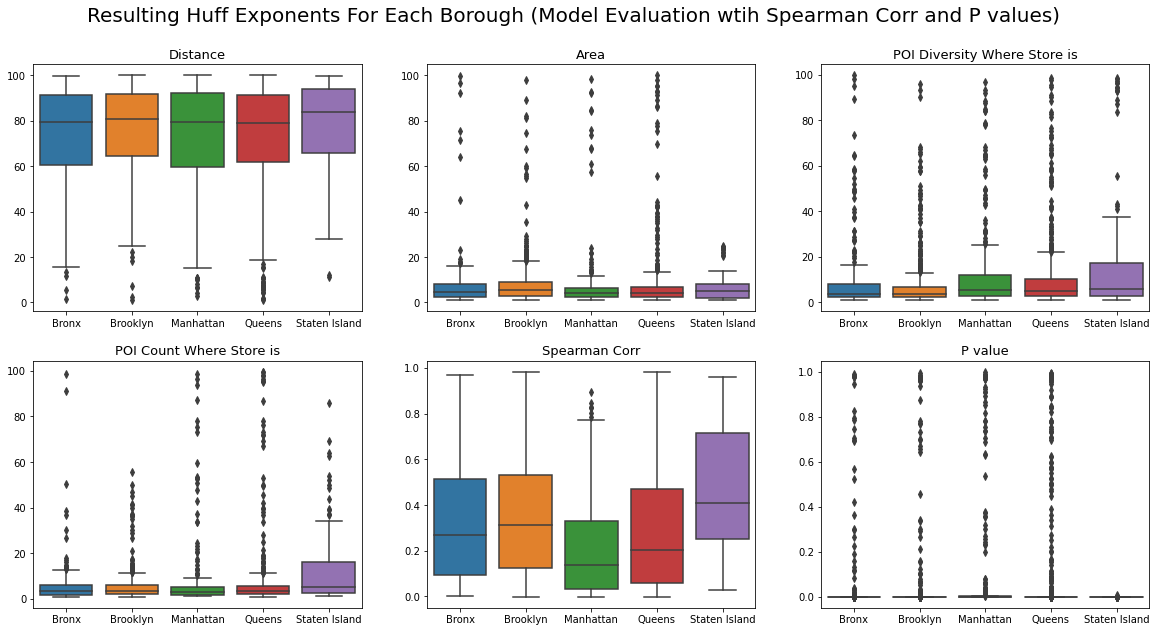

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
cols = ['exp_distance', 'exp_area', 'exp_poi_diversity', 'exp_poi_count', 'corr', 'p']
col2name = dict(zip(cols, ['Distance', 'Area', 'POI Diversity Where Store is', 'POI Count Where Store is', 'Spearman Corr', 'P value']))

for ax, col in zip(axes.flatten(), cols):
    sns.boxplot(x='borough', y=col, data=res, ax=ax)
    ax.set_title(col2name[col], fontsize=13)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
fig.suptitle('Resulting Huff Exponents For Each Borough (Model Evaluation wtih Spearman Corr and P values)', fontsize=20, y=.96)
fig.savefig(join(FIG_SAVE_DIR, 'huff-model-exps-detailed.png'), bbox_inches='tight')

In [187]:
boroughs = list(nyc_borough2fips.keys())
for borough in boroughs:
    model_params = huff_param_borough(borough, poi_locs, poi_areas, poi_cbg_ids, start_date, end_date, cbg_poi_div, cbg_poi_counts)
    pd.DataFrame(model_params).to_csv(join(HUFF_MODEL_SAVE_DIR, f'{borough}-{poi_cat}-all-features.csv'), index=False)

In [20]:
borough_population = {'Bronx': 1472654, 'Brooklyn': 2736074, 'Manhattan': 1694263, 'Queens': 2405464, 'Staten Island': 495747}
poi_cbg_ids['borough'] = poi_cbg_ids.GEOID.str[:5].apply(lambda x: nyc_fips2borough[int(x)])
poi_counts_by_borough = poi_cbg_ids.groupby('borough').size()
poi_per_capita_by_borough = poi_counts_by_borough / pd.Series(borough_population)
poi_per_capita_by_borough

borough
Bronx            0.000428
Brooklyn         0.000455
Manhattan        0.000564
Queens           0.000401
Staten Island    0.000327
dtype: float64

In [30]:
# for borough in boroughs:
#     huff_param_borough(borough, poi_locs, poi_areas, poi_cbg_ids, start_date, end_date)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.39it/s]


Staten Island 2.5979491670399835


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.34it/s]


Manhattan 0.8688690329675698


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.06s/it]


Bronx 1.227487879618382


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.30s/it]


Queens 1.6880514186276077


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.32s/it]


Brooklyn 1.3423208402116742


(F_onewayResult(statistic=273.6021300189622, pvalue=5.50302759718458e-217),
 F_onewayResult(statistic=528.82686482474, pvalue=0.0))

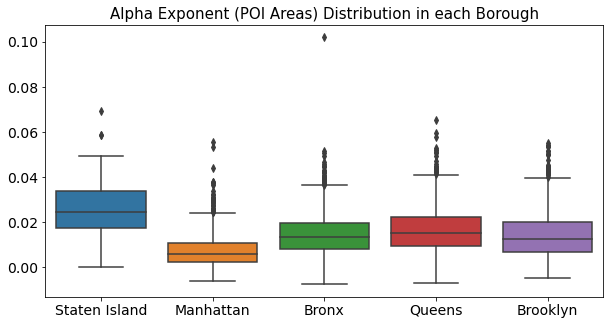

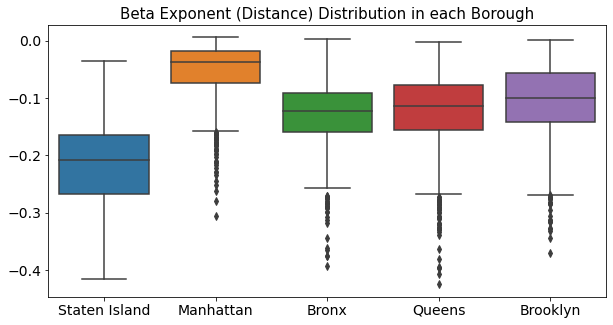

In [15]:
dfs = []
boroughs = nyc_borough2fips.keys()
for borough in boroughs:
    df = pd.read_csv(join(HUFF_MODEL_SAVE_DIR,  f'{borough}-{poi_cat}-all-features.csv'))
    dfs.append(df)
        
df = pd.concat(dfs)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(y='param', x='borough', data=df[df.parameter == 'alpha'], ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Alpha Exponent (POI Areas) Distribution in each Borough', fontsize=15)
ax.tick_params(labelsize=14)
fig.savefig(join(FIG_SAVE_DIR, 'alpha-dist-by-borough.png'))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(y='param', x='borough', data=df[df.parameter == 'beta'], ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Beta Exponent (Distance) Distribution in each Borough', fontsize=15)
ax.tick_params(labelsize=14)
fig.savefig(join(FIG_SAVE_DIR, 'beta-dist-by-borough.png'))

def test_anova(params, boroughs):
    from scipy.stats import f_oneway
    values = []
    
    for borough in boroughs:
        values.append(params[params.borough == borough].param.values)

    return f_oneway(*values)

alpha_params = df[df.parameter == 'alpha']
beta_params = df[df.parameter == 'beta']

test_anova(alpha_params, boroughs), test_anova(beta_params, boroughs)

In [16]:
# nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
# base_df = gpd.read_file(nyc_geojson)
# base_df = base_df.to_crs('EPSG:4326')
# base_df = base_df[base_df.BLKGRPCE != '0']

# base_df = base_df.merge(df, left_on='GEOID', right_on=df.index)

# fig, ax = plt.subplots(figsize=(15, 15))
# base_df[base_df['parameter'] == 'beta'].plot(ax=ax, column='param', legend=True)

In [33]:
def simulate_matching_poi_per_capita(source_borough, target_borough, poi_cat, poi_per_capita_by_borough, 
                                     borough_population, poi_counts_by_borough, poi_locs, poi_areas, 
                                     start_date, end_date, pois_in_spreader_cbgs, other_pois, non_source_borough_poi, poi_div_count, cbg_mean_div, r=1000):
    # given a pair of source and target boroughs, adjust the # of pois in source borough 
    # so that the poi per capita will be the same as target borough
    new_num_pois = poi_per_capita_by_borough[target_borough] * borough_population[source_borough]
    num_pois = poi_counts_by_borough[source_borough]
    diff = int(new_num_pois - num_pois)
    
    if diff <= 0:
        print('can not add hypothetical POIs to the given source borough')
    else:
        params_df = pd.read_csv(join(HUFF_MODEL_SAVE_DIR,  f'{borough}-{poi_cat}-all-features-ctract.csv'))
        params_df.cbg = params_df.census_tract.astype(str)
        params_df = params_df.set_index('census_tract')
            
        selected_cbgs = str(nyc_borough2fips[source_borough])
        cbg_locs = get_cbg_locs(selected_cbgs=selected_cbgs)
        
        poi_locs = poi_locs.drop('sg:1324350d09df44c7a1df7e3e1b984850')
        poi_areas = poi_areas.drop('sg:1324350d09df44c7a1df7e3e1b984850')
        
        rand_gen_poi_locs = []
        div_cbgs = []
        area_cbgs = []
        for cbg in np.random.choice(cbg_locs.index, size=diff, replace=True):
        #for cbg in cbg_locs.index:
            entry = cbg_locs.loc[cbg]
            div_cbgs.append(cbg_mean_div.loc[cbg, 'poi_diversity_where_store_is'] if cbg in cbg_mean_div.index else 1)
            area_cbgs.append(cbg_mean_div.loc[cbg, 'poi_count_where_store_is'] if cbg in cbg_mean_div.index else 1)
            rand_gen_poi_locs.append(gen_rand_loc(entry['centroid_lat'], entry['centroid_lon'], r))

        rand_gen_poi_locs = pd.DataFrame(rand_gen_poi_locs, columns=poi_locs.columns)
        sim_poi_locs = pd.concat([poi_locs, rand_gen_poi_locs])
        sim_poi_div = pd.concat([poi_div_count.loc[poi_locs.index, 'poi_diversity_where_store_is'], pd.Series(div_cbgs)])
        sim_poi_count = pd.concat([poi_div_count.loc[poi_locs.index, 'poi_count_where_store_is'], pd.Series(area_cbgs)])
        
        mean_poi_area = poi_areas.loc[poi_cbg_ids[poi_cbg_ids.borough == source_borough].index].area_square_feet.mean()
        #sim_poi_areas = pd.concat([poi_areas.area_square_feet, pd.Series(mean_poi_area).repeat(diff).reset_index(drop=True).rename('safegraph_place_id')])
        sim_poi_areas = pd.concat([poi_areas.area_square_feet, pd.Series(mean_poi_area).repeat(len(rand_gen_poi_locs)).reset_index(drop=True).rename('safegraph_place_id')])
        
        def comp_huff_mat(poi_locs, areas, poi_div, poi_count):
            dist_mat = comp_dist_matrix(cbg_locs, poi_locs)
            for cbg in dist_mat.index:
                dist_mat.loc[cbg] = dist_mat.loc[cbg] ** -(params_df.loc[cbg, 'exp_distance'] if cbg in params_df.index else params_df['exp_distance'].mean())
                dist_mat.loc[cbg] = dist_mat.loc[cbg] * (areas.loc[dist_mat.columns] ** (params_df.loc[cbg, 'exp_area'] if cbg in params_df.index else params_df['exp_area'].mean()))
                dist_mat.loc[cbg] = dist_mat.loc[cbg] * (poi_div ** (params_df.loc[cbg, 'exp_poi_diversity'] if cbg in params_df.index else params_df['exp_poi_diversity'].mean()))
                dist_mat.loc[cbg] = dist_mat.loc[cbg] * (poi_count ** (params_df.loc[cbg, 'exp_poi_count'] if cbg in params_df.index else params_df['exp_poi_count'].mean()))
                dist_mat.loc[cbg] /= dist_mat.loc[cbg].sum()
                
            return dist_mat
            
        sim_huff_mat = comp_huff_mat(sim_poi_locs, sim_poi_areas, sim_poi_div, sim_poi_count)
        
        area_series = poi_areas.area_square_feet
        act_huff_mat = comp_huff_mat(poi_locs, area_series, poi_div_count.loc[poi_locs.index, 'poi_diversity_where_store_is'], poi_div_count.loc[poi_locs.index, 'poi_count_where_store_is'])

        pattern_dir = join(pwd, dpath, 'filtered-patterns-msa', 'NYC-patterns')
        date_format = '%Y-%m-%d'
        pattern_files = [(datetime.strptime(f.split('.')[0], date_format), join(pattern_dir, f)) for f in os.listdir(pattern_dir)]

        patterns = []
        for dt, f in pattern_files:
            if dt >= start_date and dt <= end_date:
                patterns.append(f)

        poi_cbg_visits = agg_visits_by_cbgs(act_huff_mat, patterns)
        visits = poi_cbg_visits.sum(axis=1)
        
        act_visits = act_huff_mat.mul(visits, axis=0).sum(axis=0)
        sim_visits = sim_huff_mat.mul(visits, axis=0).sum(axis=0)
        
        dist_matrix = comp_dist_matrix(cbg_locs, poi_locs)
        def dist_chg(visits):
            dists = []
            for cbg in dist_matrix.index:
                visits = poi_cbg_visits.loc[cbg]
                visits = visits[visits > 0]
                dist = dist_matrix.loc[cbg, visits.index]
                dists.extend(list(dist.repeat(np.ceil(visits).astype(int).values)))
            return np.median(dists)
        
        print('Change in median distance in km', dist_chg(act_visits) - dist_chg(sim_visits))
        
        diff = sim_visits.loc[act_visits.index] - act_visits
        
        print(f'Change in visits for spreader CBGS: {diff[pois_in_spreader_cbgs].sum() / act_visits.loc[pois_in_spreader_cbgs].sum()*100:.4f}%')
        print(diff[pois_in_spreader_cbgs].mean())
        # and pct change for the remaining cbgs
        print(f'Change in visits for other CBGS: {diff[other_pois].sum() / act_visits.loc[other_pois].sum()*100:.4f}%')
        print(diff[other_pois].mean())
        print(f'Change in visits to non-{source_borough} CBGs: {diff[non_source_borough_poi].sum() / act_visits.loc[non_source_borough_poi].sum()*100:.4f}')

In [34]:
source_borough = 'Staten Island'
target_borough = 'Manhattan'
poi_cat = 'Grocery Stores'

# spreader cbgs ordered by occurrence rank
spreader_cbgs = set(get_spreader_cbgs(pct=0.75))
# find the pois in those cbgs
pois_in_spreader_cbgs = poi_cbg_ids[poi_cbg_ids.GEOID.isin(spreader_cbgs)].index 
# and the rest of the pois
other_pois = poi_cbg_ids[~poi_cbg_ids.GEOID.isin(spreader_cbgs)].index
non_source_borough_poi = poi_cbg_ids[poi_cbg_ids.borough != source_borough].index

#poi_div_count = get_cbg_poi_div_count()
#cbg_mean_div = poi_div_count.groupby('GEOID').mean()[['poi_diversity_where_store_is', 'poi_count_where_store_is']]

res = simulate_matching_poi_per_capita(source_borough, target_borough, poi_cat, poi_per_capita_by_borough, 
                                     borough_population, poi_counts_by_borough, poi_locs, poi_areas, 
                                     start_date, end_date, pois_in_spreader_cbgs, other_pois, non_source_borough_poi, poi_div_count.set_index('safegraph_place_id'), cbg_mean_div, r=1000)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.45it/s]


Change in median distance in km 0.0
Change in visits for spreader CBGS: -0.1780%
-0.15643012985358543
Change in visits for other CBGS: -0.1889%
-0.005636026874510446
Change in visits to non-Staten Island CBGs: -0.3118
